#### To use the Random Forest Survival analysis you will need to use the Pysurvival package.
To install this package please follow the instructions from this site https://square.github.io/pysurvival/installation.html
##### For MacOS users:
You will need to add two more lines besides the recommended 2 as shown below:
###### Note: please check which version of gcc do you have as it might be different from 9.3.0.



### To use the Random Forest Survival analysis we need to load the data and remove the colinear features

In [40]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import os

from pysurvival.utils.display import correlation_matrix
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import compare_to_actual
from pysurvival.utils.display import integrated_brier_score

from sklearn.model_selection import StratifiedKFold
from statistics import mean 

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
sns.set()
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [2]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=20.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [47]:
# feature selection function by VIF and removing low variance features

def feature_select(file_name):
    data = pd.read_csv(file_name)

    data['time column']= data['FFLP_in_months']
    data['event column']= data['FFLP']

    data1=data.drop(columns=['filename', 'Unnamed: 0'])
    lola=data1.iloc[:,0:255]

    time_column='time column'
    event_column='event column'
    features=np.setdiff1d(data1.columns, [time_column, event_column]).tolist()

    #VIF of 10 means that all the features with R^2 above 0.9 will removed
    X = lola
    data2 = calculate_vif_(X, 10)
    data2[['time column']] = lola[['time column']]

    #removing low variance features
    data_temp = data2
    for cols in data2.columns:
        if np.var(data2[cols]) == 0:
            print('Dropping: ' + cols)
            data_temp = data_temp.drop(columns=cols)

    data2 = data_temp
    
    # saving a copy to not repeat VIF again
    processedFileName = 'filtered_' + file_name
    data2.to_csv(processedFileName)

    return data2

In [158]:
# Gridsearch funciton for random survival forest

def gridsearch(data2, file_name):
    features=np.setdiff1d(data2.columns, [time_column, event_column]).tolist()
    X = data2[features]

    newX=np.setdiff1d(data2.columns, [event_column]).tolist()
    X=data2[newX]
    E=data2['event column']

    num_tree=(10, 12, 15, 20, 50, 100)
    max_depth=(1, 2, 3, 4, 5, 6, 10, 12, 15)
    min_node=(1, 2, 3, 4, 5, 10, 12, 15, 20)

    Xnew = X
    Enew = E
    features2 = features

    num_tree_best = 0
    max_depth_best = 0
    min_node_best = 0
    c_index_best = 0

    for a in num_tree:
        for b in max_depth:
            for c in min_node:
                cc=[]
                kf=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
                i=1
                for train_index, test_index in kf.split(Xnew,Enew):
                    X1_train, X1_test=Xnew.loc[train_index], Xnew.loc[test_index]
                    X_train, X_test=X1_train[features2], X1_test[features2]
                    T_train, T_test=X1_train['time column'].values, X1_test['time column'].values
                    E_train, E_test=Enew.loc[train_index].values, Enew.loc[test_index].values
                    xst = RandomSurvivalForestModel(num_trees=a) 
                    xst.fit(X_train, T_train, E_train, max_features = 'sqrt', max_depth = b,
                    min_node_size = c, num_threads = -1, 
                    sample_size_pct = 0.63, importance_mode = 'normalized_permutation',
                    seed = None, save_memory=False )
                    from pysurvival.utils.metrics import concordance_index
                    c_index = concordance_index(xst, X_test, T_test, E_test)
                    cc.append(c_index)
                i=i+1
                print(a, b, c, mean(cc))
                if mean(cc) > c_index_best:
                    c_index_best = mean(cc)
                    num_tree_best = a
                    max_depth_best = b
                    min_node_best = c
                    
    # saving a copy to not repeat grisearch again
    processedFileName = 'gridsearch_' + file_name           
    toDF = [c_index_best, num_tree_best, max_depth_best, min_node_best]
    gridsearchDF = pd.DataFrame(toDF,columns=['Values'])
    gridsearchDF.to_csv(processedFileName)
    
    return (c_index_best, num_tree_best, max_depth_best, min_node_best)

In [149]:
def generate_survival_model(data2, num_trees_best, max_depth_best, min_node_best):
    # retraining with best gridsearch hyperparameters, manually entering them as variables, probably can automate this from picking out max acc
    # Creating the X, T and E inputs
    features=np.setdiff1d(data2.columns, [time_column, event_column]).tolist()
    X = data2[features]
    
    newX=np.setdiff1d(data2.columns, [event_column]).tolist()
    
    X=data2[newX]
    E=data2['event column']

    CI = []
    IBS = []

    k_folds = 5
    i=1
    kf=StratifiedKFold(n_splits=k_folds, random_state=42, shuffle=True)
    for train_index, test_index in kf.split(X,E):
        print('\n {} of kfold {}'.format(i,kf.n_splits)) 
        X1_train, X1_test=X.loc[train_index], X.loc[test_index]
        X_train, X_test=X1_train[features], X1_test[features]
        T_train, T_test=X1_train['time column'].values, X1_test['time column'].values
        E_train, E_test=E.loc[train_index].values, E.loc[test_index].values
        xst = RandomSurvivalForestModel(num_trees=num_tree_best) 
        xst.fit(X_train, T_train, E_train, max_features = 'sqrt', max_depth = max_depth_best,
            min_node_size = min_node_best, num_threads = -1, 
            sample_size_pct = 0.63, importance_mode = 'normalized_permutation',
            seed = None, save_memory=False )
        c_index = concordance_index(xst, X_test, T_test, E_test)

        #results = compare_to_actual(xst, X_test, T_test, E_test, is_at_risk = True,  figure_size=(16, 6), 
        #                            metrics = ['rmse', 'mean', 'median'])
        ibs = integrated_brier_score(xst, X_test, T_test, E_test, t_max=100, figure_size=(15,5))
        CI.append(c_index)
        IBS.append(ibs)
        print('C-index: {:.2f}'.format(c_index))
        print('IBS: {:.2f}'.format(ibs))           
        i=i+1

    CIAvg = mean(CI)
    CIStd = statistics.stdev(CI)
    IBSAvg = mean(IBS)
    IBSStd = statistics.stdev(IBS)
    
    return(CIAvg, CIStd, IBSAvg, IBSStd)


### Main script starts here

In [64]:
# Loading all the data
# Single run of all datasets below, separate single-use code at bottom

gtv = 'gtv.csv'
liver_sub_gtv = 'liver_sub_gtv.csv'
liver_plus_gtv = 'liver_plus_gtv.csv'

gtv_clin_variables = 'gtv_clin_variables.csv'
liver_sub_gtv_clin_variables = 'liver_sub_gtv_clin_variables.csv'
liver_plus_gtv_clin_variables = 'liver_plus_gtv_clin_variables.csv'

clin_variables_only = 'clin_variables_only.csv'
data_list = list()
data_list.extend((gtv, liver_sub_gtv, liver_plus_gtv, gtv_clin_variables, liver_sub_gtv_clin_variables, liver_plus_gtv_clin_variables, clin_variables_only))

Processing: gtv.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: gtv.csv

Computing gridsearch...

10 1 1 0.5648937278503016
10 1 2 0.6031248795382534
10 1 3 0.6617877682924636
10 1 4 0.6595262668020582
10 1 5 0.6264780530317016
10 1 10 0.6686170100053891
10 1 12 0.667773522279171
10 1 15 0.6985012766858494
10 1 20 0.6401701218248904
10 2 1 0.6079883010912498
10 2 2 0.595585629390115
10 2 3 0.6878318782875834
10 2 4 0.6435589284033952
10 2 5 0.6700202070649921
10 2 10 0.6793482584064201
10 2 12 0.6537962875521589
10 2 15 0.6800950036631292
10 2 20 0.6194008516617757
10 3 1 0.6718649830312817
10 3 2 0.6619056951285266
10 3 3 0.694489169845076
10 3 4 0.6651367223801468
10 3 5 0.6482594489886239
10 3 10 0.691126630625486
10 3 12 0.6245698275543649
10 3 15 0.6713993673776939
10 3 20 0.6540959974319067
10 4 1 0.6304172047625315
10 4 2 0.6733307616171349
10 4 3 0.6621951143370074
10 4 4 0.6225439238494137
10 4 5 0.6477147650359694
10 4 10 0.700010

20 10 12 0.6797637659572472
20 10 15 0.6312366089551914
20 10 20 0.6243660535268514
20 12 1 0.6214760572466147
20 12 2 0.6312132665320804
20 12 3 0.6872734734311701
20 12 4 0.6692623666146512
20 12 5 0.6962431911821801
20 12 10 0.6697775227501087
20 12 12 0.6496868148310038
20 12 15 0.6607455055493737
20 12 20 0.6932953433584084
20 15 1 0.6140208720050495
20 15 2 0.6867309209559398
20 15 3 0.6756439688097566
20 15 4 0.6719554927748307
20 15 5 0.6967432844839969
20 15 10 0.6718090578297281
20 15 12 0.6868716735020158
20 15 15 0.6594320459496517
20 15 20 0.6399963750661523
50 1 1 0.6546366350709831
50 1 2 0.7026392592567634
50 1 3 0.6541034797097758
50 1 4 0.6864968074682649
50 1 5 0.7002518541490046
50 1 10 0.7168324325120469
50 1 12 0.6707877767431497
50 1 15 0.6710531997231216
50 1 20 0.6966184900586039
50 2 1 0.6666225951886134
50 2 2 0.6800449537822967
50 2 3 0.6866610897967366
50 2 4 0.6847488577252865
50 2 5 0.7040600424296976
50 2 10 0.6991061277259367
50 2 12 0.6886324165890877


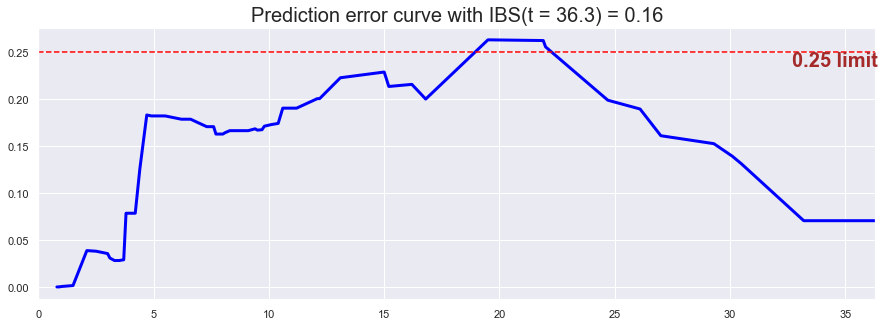

C-index: 0.65
IBS: 0.16

 2 of kfold 5


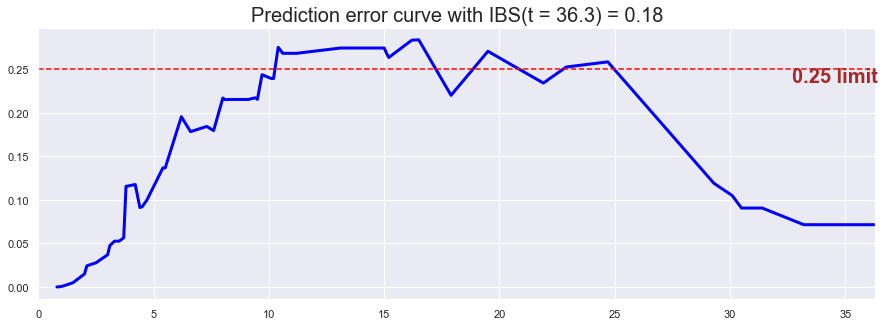

C-index: 0.54
IBS: 0.18

 3 of kfold 5


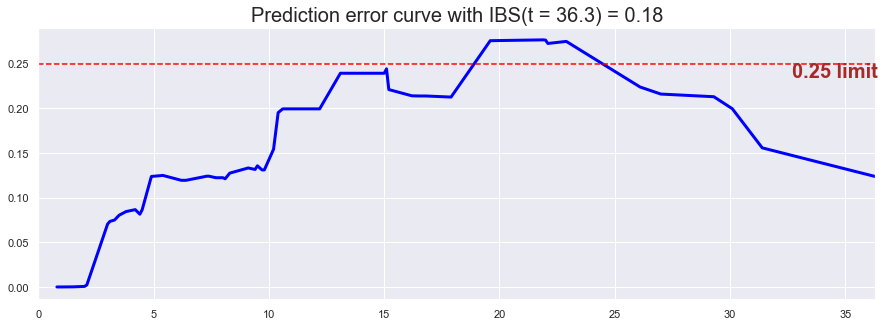

C-index: 0.71
IBS: 0.18

 4 of kfold 5


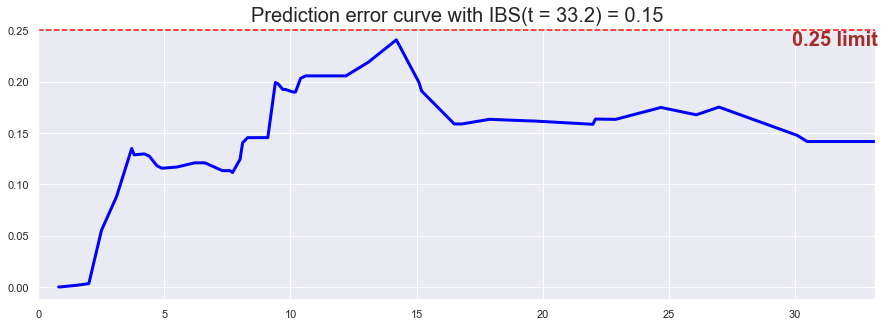

C-index: 0.64
IBS: 0.15

 5 of kfold 5


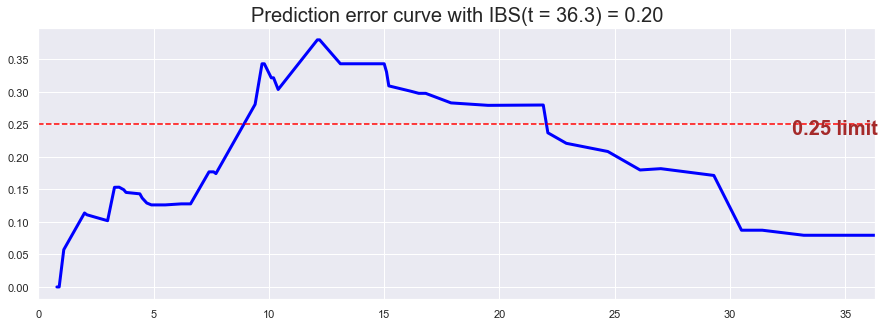

C-index: 0.73
IBS: 0.20

 

Processing: liver_sub_gtv.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_sub_gtv.csv

Computing gridsearch...

10 1 1 0.6365376968914949
10 1 2 0.6134825047376726
10 1 3 0.6410458759979057
10 1 4 0.6507310225871444
10 1 5 0.6853708615622022
10 1 10 0.6934934500304517
10 1 12 0.6811792846996787
10 1 15 0.7690142030703897
10 1 20 0.7548096712520519
10 2 1 0.6692744021421374
10 2 2 0.6583417785817546
10 2 3 0.667236900223854
10 2 4 0.7269193436575866
10 2 5 0.746894210391464
10 2 10 0.761317597330078
10 2 12 0.7018642335487808
10 2 15 0.6893004086401323
10 2 20 0.7299746094599553
10 3 1 0.7604774186320801
10 3 2 0.7688913558746502
10 3 3 0.739961357924173
10 3 4 0.7501961271758596
10 3 5 0.6594567555928271
10 3 10 0.7123091083302621
10 3 12 0.7213579616380319
10 3 15 0.6709486121198025
10 3 20 0.7108139712141434
10 4 1 0.7511435374610167
10 4 2 0.7250513729021483
10 4 3 0.7177629114447845
10 4 4 0.78294344728

20 10 5 0.7409336236538671
20 10 10 0.7833840983634777
20 10 12 0.8160456462066075
20 10 15 0.7867627151685621
20 10 20 0.7772781207426865
20 12 1 0.7710518901989405
20 12 2 0.7404315035684785
20 12 3 0.7711749126692093
20 12 4 0.7154701701100088
20 12 5 0.7522075168373628
20 12 10 0.7868739578677137
20 12 12 0.7928286296693131
20 12 15 0.806851491341202
20 12 20 0.7278487942672529
20 15 1 0.7212076724863976
20 15 2 0.7297092646833699
20 15 3 0.7135267046364248
20 15 4 0.7383407951488288
20 15 5 0.7603850694581018
20 15 10 0.7966961992387072
20 15 12 0.7537089507122374
20 15 15 0.7927349262234074
20 15 20 0.7467280942778929
50 1 1 0.670428319358304
50 1 2 0.6778582607884239
50 1 3 0.6959578772578092
50 1 4 0.6946120971217508
50 1 5 0.6754952934824324
50 1 10 0.7569290071536551
50 1 12 0.7572471547642224
50 1 15 0.8234983815092732
50 1 20 0.8059601473102026
50 2 1 0.7553817604918925
50 2 2 0.6731210117961254
50 2 3 0.7150926918381855
50 2 4 0.752278013375019
50 2 5 0.76481463962976
50 2

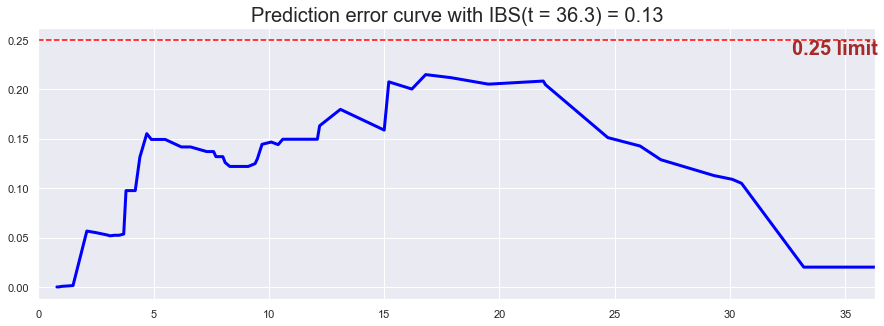

C-index: 0.83
IBS: 0.13

 2 of kfold 5


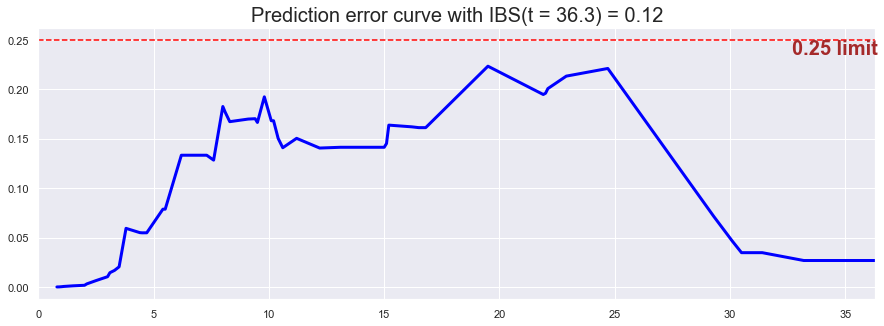

C-index: 0.79
IBS: 0.12

 3 of kfold 5


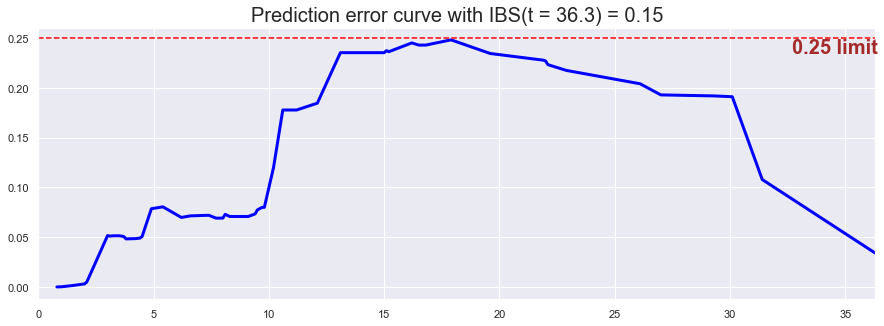

C-index: 0.65
IBS: 0.15

 4 of kfold 5


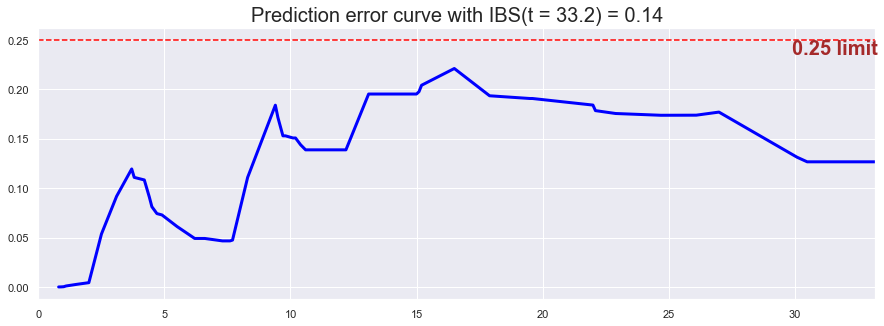

C-index: 0.76
IBS: 0.14

 5 of kfold 5


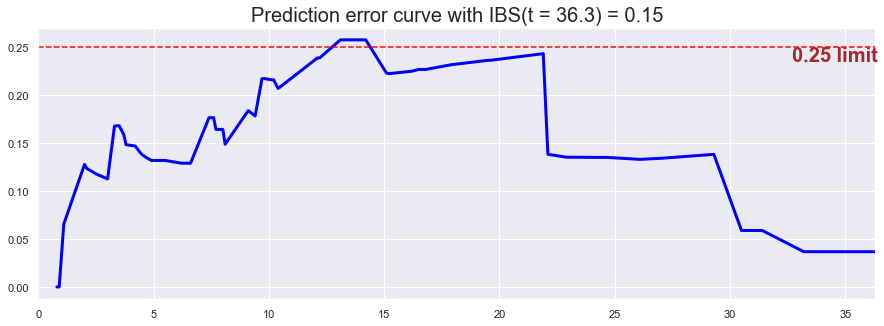

C-index: 0.82
IBS: 0.15

 

Processing: liver_plus_gtv.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_plus_gtv.csv

Computing gridsearch...

10 1 1 0.5789689613901948
10 1 2 0.6092899935387835
10 1 3 0.5896732380769526
10 1 4 0.58370074124543
10 1 5 0.572072021715428
10 1 10 0.5852340749645354
10 1 12 0.6137997376208272
10 1 15 0.5482943309070666
10 1 20 0.5923146933456428
10 2 1 0.6052850946157428
10 2 2 0.5542588738290793
10 2 3 0.5936703920385852
10 2 4 0.5967836870891525
10 2 5 0.5995661411923136
10 2 10 0.572753131794547
10 2 12 0.5969150591116282
10 2 15 0.5839843069269655
10 2 20 0.6235963897804775
10 3 1 0.6123679171226
10 3 2 0.5660059057479984
10 3 3 0.5861896374880387
10 3 4 0.6145159355275644
10 3 5 0.6736517692294766
10 3 10 0.6661625391841531
10 3 12 0.5916704957259394
10 3 15 0.6030825390798003
10 3 20 0.6000535973323449
10 4 1 0.5957097606036693
10 4 2 0.5891061168738317
10 4 3 0.5811056347990253
10 4 4 0.598226440384

20 10 5 0.559374756925285
20 10 10 0.5621320525164778
20 10 12 0.5838095402611668
20 10 15 0.5958186510255489
20 10 20 0.593425418803498
20 12 1 0.6506186293606928
20 12 2 0.5901791001838512
20 12 3 0.583594409287716
20 12 4 0.5746402022722403
20 12 5 0.5571992557966181
20 12 10 0.5793315509341971
20 12 12 0.586037763365409
20 12 15 0.6193703713015031
20 12 20 0.5488097387768616
20 15 1 0.6373125326140975
20 15 2 0.564596608228815
20 15 3 0.5962200497515345
20 15 4 0.5596016608053553
20 15 5 0.603543380058455
20 15 10 0.6030922328116279
20 15 12 0.5977246251612751
20 15 15 0.5816031430907274
20 15 20 0.5847436905702437
50 1 1 0.6183634009260147
50 1 2 0.6010718293627864
50 1 3 0.6269343748459317
50 1 4 0.5499789839036331
50 1 5 0.5558072618826613
50 1 10 0.6103807539857016
50 1 12 0.5721485020747078
50 1 15 0.5691917753617638
50 1 20 0.6057161873509068
50 2 1 0.5767514711133663
50 2 2 0.5791003956342361
50 2 3 0.5958640630767733
50 2 4 0.586846263295818
50 2 5 0.6245226674444279
50 2 1

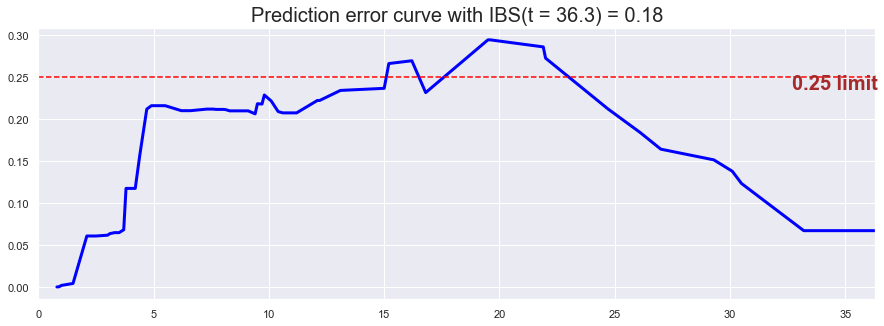

C-index: 0.53
IBS: 0.18

 2 of kfold 5


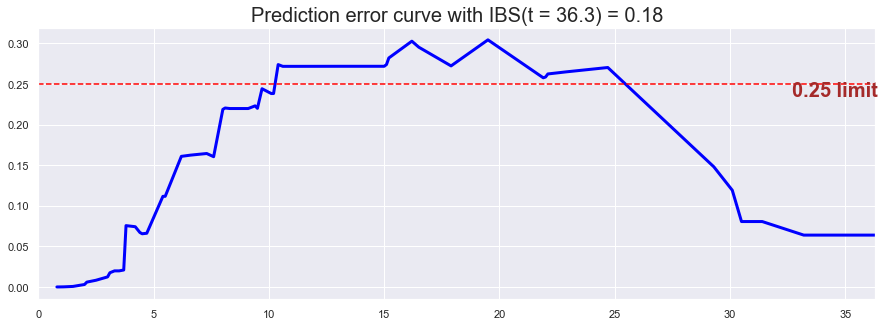

C-index: 0.62
IBS: 0.18

 3 of kfold 5


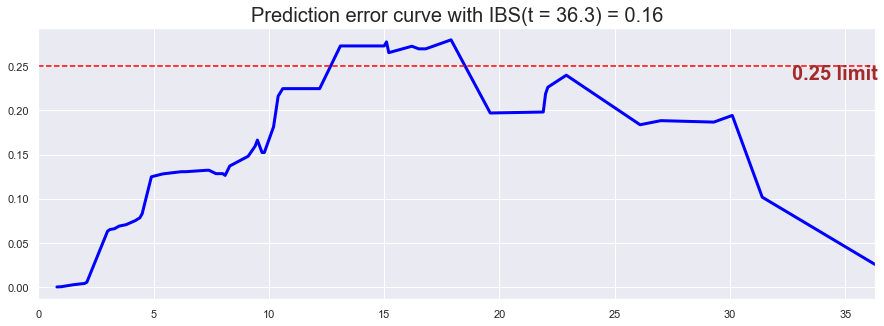

C-index: 0.65
IBS: 0.16

 4 of kfold 5


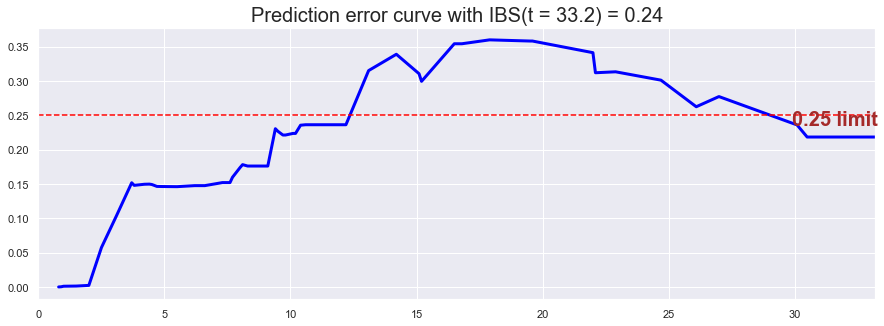

C-index: 0.67
IBS: 0.24

 5 of kfold 5


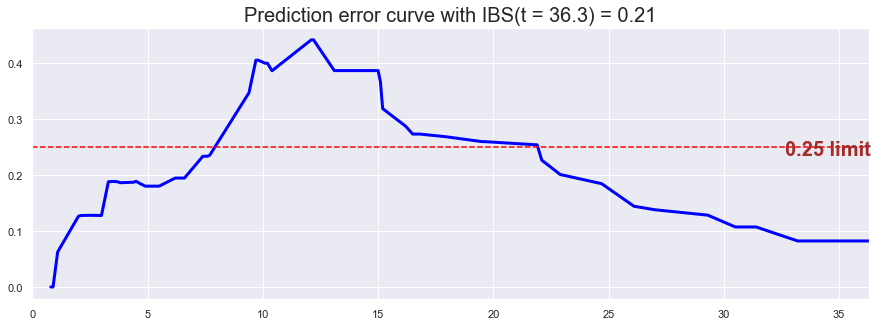

C-index: 0.58
IBS: 0.21

 

Processing: gtv_clin_variables.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: gtv_clin_variables.csv

Computing gridsearch...

10 1 1 0.6299425802632018
10 1 2 0.6933751659069244
10 1 3 0.6569113195699527
10 1 4 0.6425032161777336
10 1 5 0.7016784426263319
10 1 10 0.6847226904650865
10 1 12 0.6653204768531825
10 1 15 0.6270408870991595
10 1 20 0.6906817342199869
10 2 1 0.7028815202174059
10 2 2 0.6126606458110959
10 2 3 0.659150052006274
10 2 4 0.6749121972776947
10 2 5 0.672862059232063
10 2 10 0.6740754366300085
10 2 12 0.6766240232352041
10 2 15 0.6423869931571429
10 2 20 0.6513355457265044
10 3 1 0.6180603731977907
10 3 2 0.6848005515816065
10 3 3 0.6204201532895929
10 3 4 0.720483827037804
10 3 5 0.6981858827116673
10 3 10 0.6899988054919755
10 3 12 0.6641966356274543
10 3 15 0.6383023976498827
10 3 20 0.6474295008144727
10 4 1 0.6180225935858332
10 4 2 0.6728663651275865
10 4 3 0.6653840450804369
10 4 4 0.

20 10 5 0.6485236193766933
20 10 10 0.6968152839681434
20 10 12 0.7114935135348898
20 10 15 0.6490843128513195
20 10 20 0.6623464356162371
20 12 1 0.7266838732558842
20 12 2 0.7119316613239446
20 12 3 0.6837126743540565
20 12 4 0.6877392035229093
20 12 5 0.6812555959142612
20 12 10 0.6978287894537105
20 12 12 0.6539386650881767
20 12 15 0.7000054218961042
20 12 20 0.645013009822938
20 15 1 0.6858768790446718
20 15 2 0.7208266850672896
20 15 3 0.710046757815462
20 15 4 0.7339960174625784
20 15 5 0.7086501229786977
20 15 10 0.6570424816755376
20 15 12 0.7262538980464988
20 15 15 0.690735518070082
20 15 20 0.662516157266362
50 1 1 0.7075014809391383
50 1 2 0.564164869910019
50 1 3 0.6706077780100055
50 1 4 0.6431801976915061
50 1 5 0.6795242072781236
50 1 10 0.7319909092202176
50 1 12 0.6985456635318984
50 1 15 0.6605520433974991
50 1 20 0.6476217062786764
50 2 1 0.6849491543794548
50 2 2 0.6684160356062411
50 2 3 0.6617544472181144
50 2 4 0.6939556239212966
50 2 5 0.6966701859177638
50 2

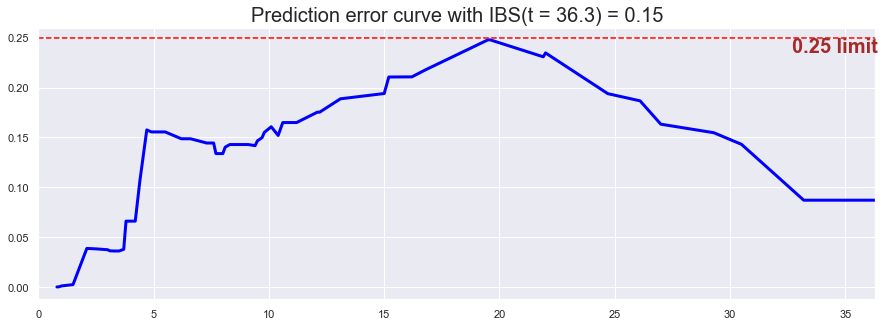

C-index: 0.73
IBS: 0.15

 2 of kfold 5


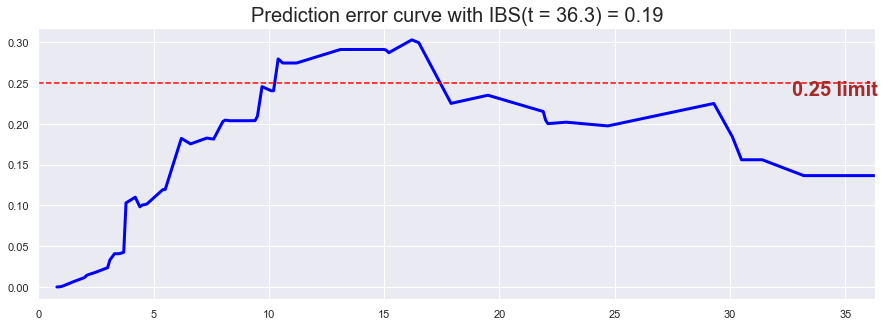

C-index: 0.62
IBS: 0.19

 3 of kfold 5


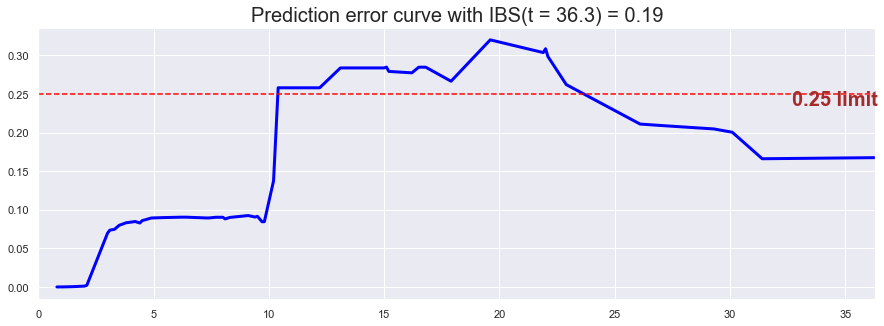

C-index: 0.64
IBS: 0.19

 4 of kfold 5


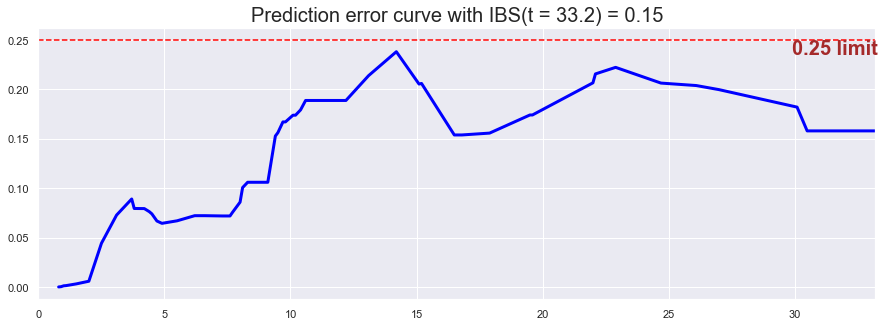

C-index: 0.64
IBS: 0.15

 5 of kfold 5


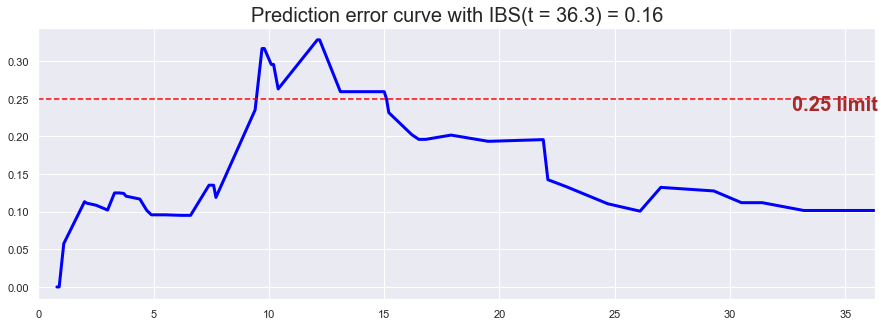

C-index: 0.88
IBS: 0.16

 

Processing: liver_sub_gtv_clin_variables.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_sub_gtv_clin_variables.csv

Computing gridsearch...

10 1 1 0.5711665643752413
10 1 2 0.5928692960907096
10 1 3 0.6286054026059064
10 1 4 0.6054434890652203
10 1 5 0.5777010333774677
10 1 10 0.6562708394226666
10 1 12 0.6125075124984871
10 1 15 0.6086898014909595
10 1 20 0.5935841931283029
10 2 1 0.6715665718324272
10 2 2 0.6292629508136462
10 2 3 0.5798063937611616
10 2 4 0.6358476273786852
10 2 5 0.6865838060095139
10 2 10 0.6284958355464958
10 2 12 0.6233604873077483
10 2 15 0.5737770819838557
10 2 20 0.57270583448003
10 3 1 0.6852939426469618
10 3 2 0.6133183521989629
10 3 3 0.6168816349176874
10 3 4 0.61796454520574
10 3 5 0.5544273258146123
10 3 10 0.6254009818772756
10 3 12 0.566859055493702
10 3 15 0.6299392574972847
10 3 20 0.6344924939890241
10 4 1 0.5735461811214339
10 4 2 0.5459770374596837
10 4 3 0.58166670

20 10 4 0.6481811722438728
20 10 5 0.6312842826332675
20 10 10 0.6067278601912133
20 10 12 0.5876828585146652
20 10 15 0.6439780082170965
20 10 20 0.6090152181700346
20 12 1 0.5894300987796967
20 12 2 0.579361205048289
20 12 3 0.5834713064183337
20 12 4 0.6226338512041439
20 12 5 0.6274481788502245
20 12 10 0.605363164599609
20 12 12 0.6658623643944737
20 12 15 0.6189598498217913
20 12 20 0.5508904070948129
20 15 1 0.5928634184981292
20 15 2 0.6409784835569505
20 15 3 0.6388464309848861
20 15 4 0.6224877950762199
20 15 5 0.6526664303851358
20 15 10 0.6657221892066334
20 15 12 0.6400957606451756
20 15 15 0.5985598843979807
20 15 20 0.5776003268934462
50 1 1 0.6266809986049441
50 1 2 0.6777554901439546
50 1 3 0.6465698789596342
50 1 4 0.6537205189590799
50 1 5 0.660141471387147
50 1 10 0.6446575865949631
50 1 12 0.5870214752215815
50 1 15 0.6158880547149758
50 1 20 0.6047464212223591
50 2 1 0.5673458210728084
50 2 2 0.6449509070770972
50 2 3 0.6517415531214085
50 2 4 0.6834229247727104
5

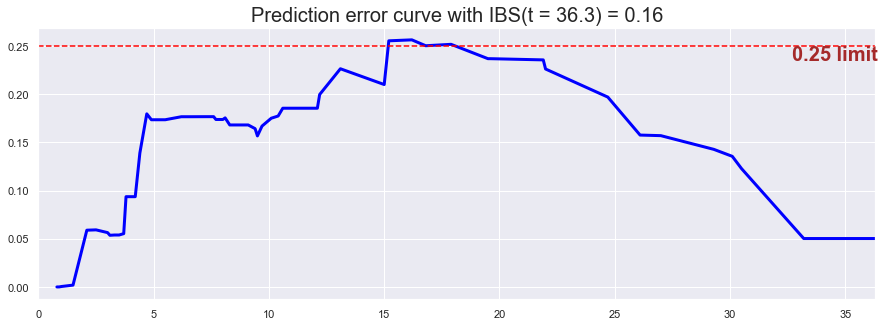

C-index: 0.71
IBS: 0.16

 2 of kfold 5


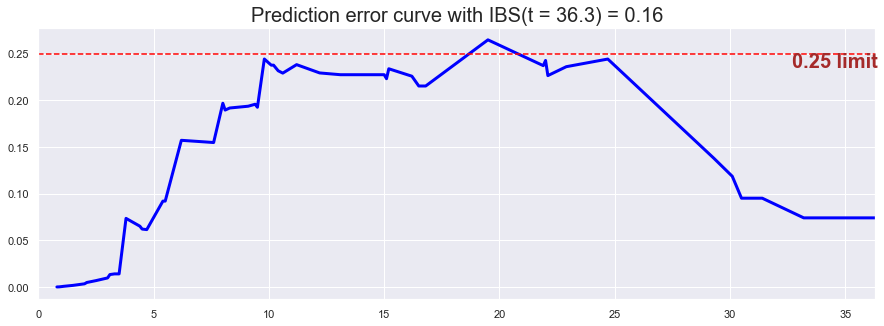

C-index: 0.74
IBS: 0.16

 3 of kfold 5


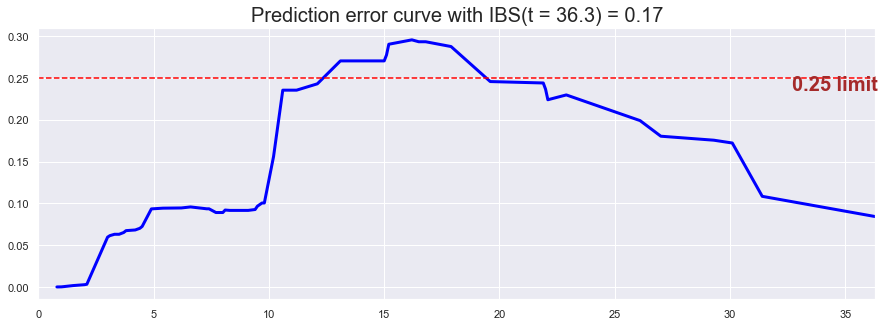

C-index: 0.60
IBS: 0.17

 4 of kfold 5


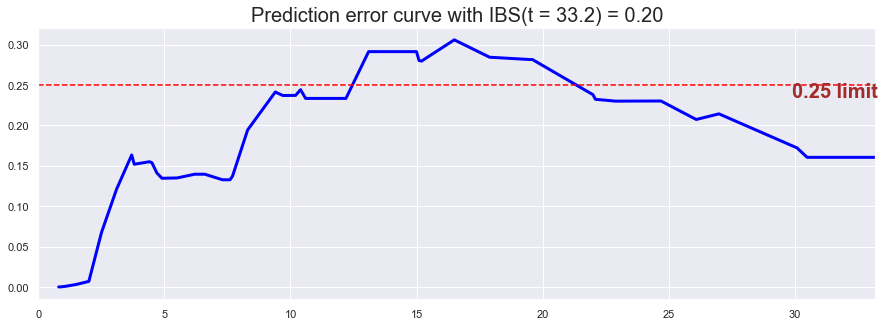

C-index: 0.68
IBS: 0.20

 5 of kfold 5


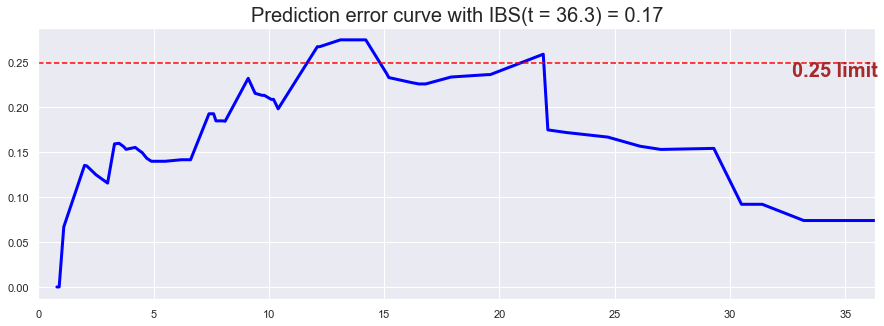

C-index: 0.81
IBS: 0.17

 

Processing: liver_plus_gtv_clin_variables.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_plus_gtv_clin_variables.csv

Computing gridsearch...

10 1 1 0.6333276240091005
10 1 2 0.6924277883834765
10 1 3 0.6764118177313185
10 1 4 0.634683180537189
10 1 5 0.6741552944144825
10 1 10 0.5943499299782085
10 1 12 0.7682403264136868
10 1 15 0.6695896377285266
10 1 20 0.6686551514485349
10 2 1 0.696734198593089
10 2 2 0.718460551252517
10 2 3 0.6453602284552885
10 2 4 0.6798576770314226
10 2 5 0.7817089173031972
10 2 10 0.7013421456467446
10 2 12 0.7368863531245471
10 2 15 0.7718010933063331
10 2 20 0.6776398721742727
10 3 1 0.6750425114599086
10 3 2 0.7660938600697715
10 3 3 0.7416343426889285
10 3 4 0.6220696235038592
10 3 5 0.7254259487476465
10 3 10 0.677775320379505
10 3 12 0.7415823715551483
10 3 15 0.6948305806923506
10 3 20 0.7074440625804018
10 4 1 0.7536573873941987
10 4 2 0.6731369545398294
10 4 3 0.73797

20 10 4 0.7363595553571938
20 10 5 0.7957712469452447
20 10 10 0.8126628212608528
20 10 12 0.7913925919947377
20 10 15 0.7386753398306355
20 10 20 0.7765849288212487
20 12 1 0.7242734469932918
20 12 2 0.7771012368550619
20 12 3 0.7907431357705355
20 12 4 0.7817756191026343
20 12 5 0.8201634521561466
20 12 10 0.6989704182307713
20 12 12 0.7329063971153406
20 12 15 0.818210286325024
20 12 20 0.7335701415186805
20 15 1 0.7285147783865967
20 15 2 0.7889552611960103
20 15 3 0.774522276595756
20 15 4 0.7885020107490088
20 15 5 0.7940657147290704
20 15 10 0.7382815782554897
20 15 12 0.7448971361329227
20 15 15 0.8165458848093702
20 15 20 0.776785389191095
50 1 1 0.7114628895791567
50 1 2 0.6643960189369791
50 1 3 0.7305657519079283
50 1 4 0.7028370816241418
50 1 5 0.722687076403048
50 1 10 0.7208353551078854
50 1 12 0.782048548731548
50 1 15 0.7607071978008636
50 1 20 0.7381024577244567
50 2 1 0.7625030022908821
50 2 2 0.7451273348778735
50 2 3 0.7480020333501093
50 2 4 0.783704694659653
50 2

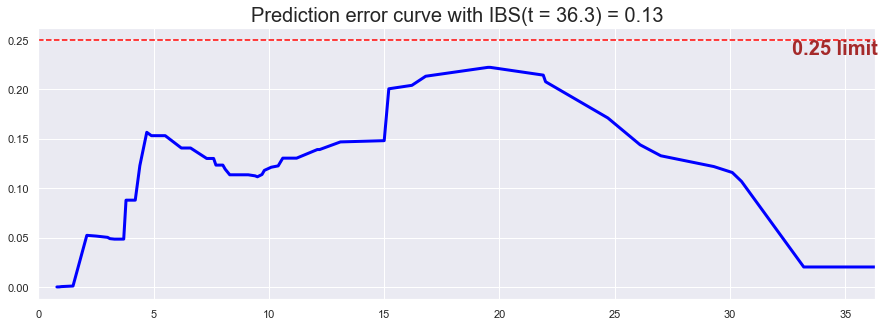

C-index: 0.73
IBS: 0.13

 2 of kfold 5


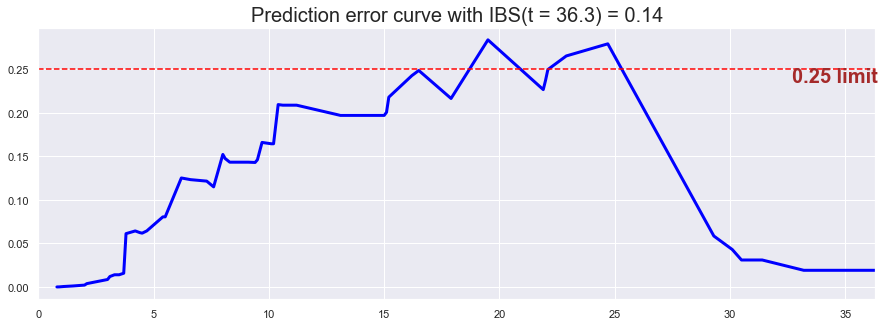

C-index: 0.80
IBS: 0.14

 3 of kfold 5


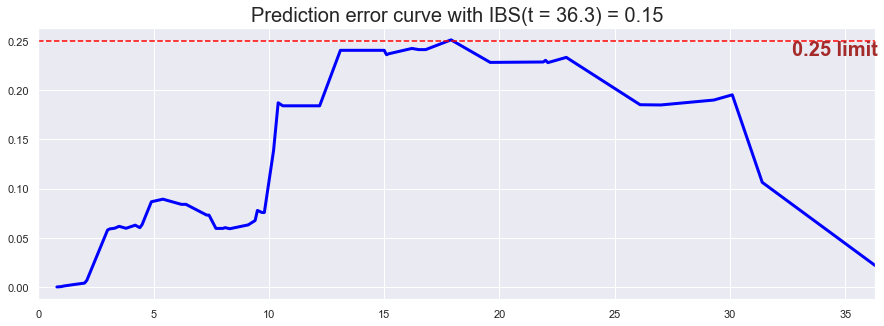

C-index: 0.61
IBS: 0.15

 4 of kfold 5


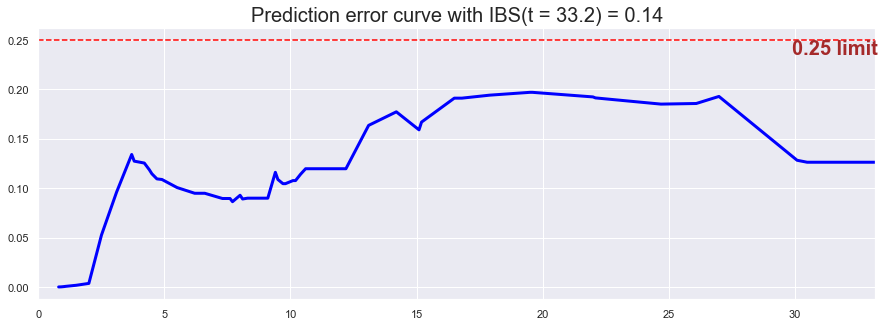

C-index: 0.86
IBS: 0.14

 5 of kfold 5


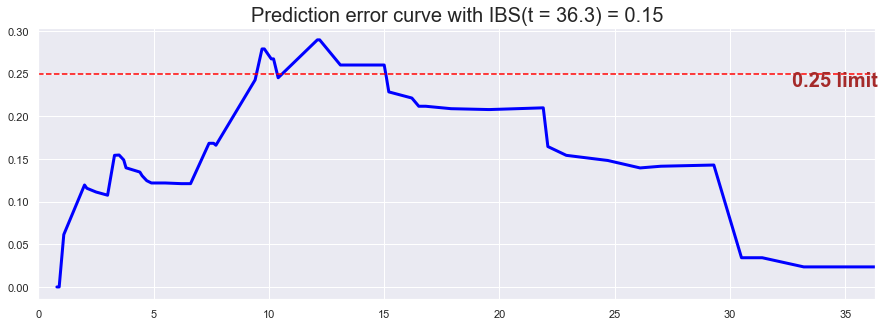

C-index: 0.83
IBS: 0.15

 

Processing: clin_variables_only.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: clin_variables_only.csv

Computing gridsearch...

10 1 1 0.6282405686595365
10 1 2 0.7437983269486752
10 1 3 0.6972154799485338
10 1 4 0.7236063606219607
10 1 5 0.7794226003860943
10 1 10 0.7854251746648496
10 1 12 0.6890417695277343
10 1 15 0.7277771780103911
10 1 20 0.7356248473162175
10 2 1 0.6765235699963393
10 2 2 0.7293456478651357
10 2 3 0.6525280672825181
10 2 4 0.733397042504122
10 2 5 0.7144198299632041
10 2 10 0.744848227304556
10 2 12 0.737571877461465
10 2 15 0.7184429759625416
10 2 20 0.6613395528972825
10 3 1 0.666676155278718
10 3 2 0.6826019424264288
10 3 3 0.718483518600311
10 3 4 0.6659751754126393
10 3 5 0.7354087822298677
10 3 10 0.7631739246336547
10 3 12 0.664045424925082
10 3 15 0.733154493960395
10 3 20 0.6679889687898327
10 4 1 0.663643358763017
10 4 2 0.731995765657999
10 4 3 0.6930038560391498
10 4 4 0.7025

20 10 10 0.7267188457462884
20 10 12 0.7437047478284283
20 10 15 0.7384167133502126
20 10 20 0.6957534416668073
20 12 1 0.6912922934441382
20 12 2 0.7202125306612422
20 12 3 0.7320482209532005
20 12 4 0.7224606358937937
20 12 5 0.6610299870154149
20 12 10 0.7455439609966035
20 12 12 0.7569673813838883
20 12 15 0.7344529912168722
20 12 20 0.6645759802209626
20 15 1 0.656287404620539
20 15 2 0.7360012612428798
20 15 3 0.73389296874852
20 15 4 0.6968185117871022
20 15 5 0.7260501469094538
20 15 10 0.712737799785987
20 15 12 0.7214503635927081
20 15 15 0.7161731811447696
20 15 20 0.6573310721316238
50 1 1 0.7594559282347393
50 1 2 0.7255709300820017
50 1 3 0.7215045345278379
50 1 4 0.7454620686847419
50 1 5 0.7871011635581164
50 1 10 0.7344358669157668
50 1 12 0.7203532979172361
50 1 15 0.7506290328705469
50 1 20 0.689503866722406
50 2 1 0.7595156311638098
50 2 2 0.7728406016862186
50 2 3 0.6907724470249006
50 2 4 0.6964390763808009
50 2 5 0.7445445238958588
50 2 10 0.7536244543624208
50 2

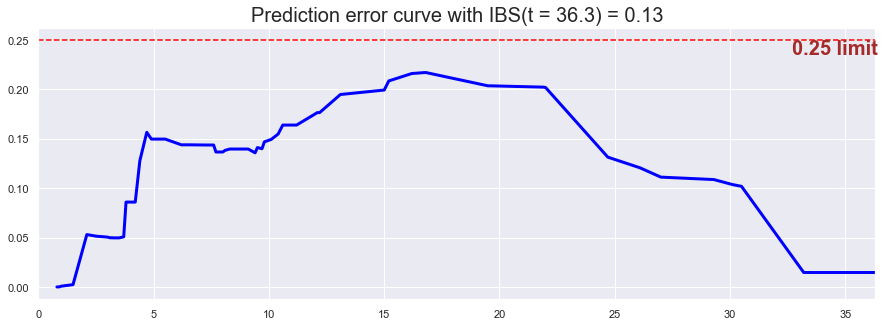

C-index: 0.70
IBS: 0.13

 2 of kfold 5


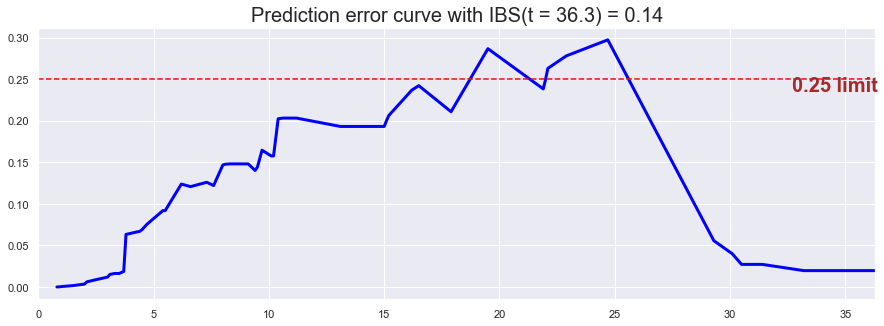

C-index: 0.80
IBS: 0.14

 3 of kfold 5


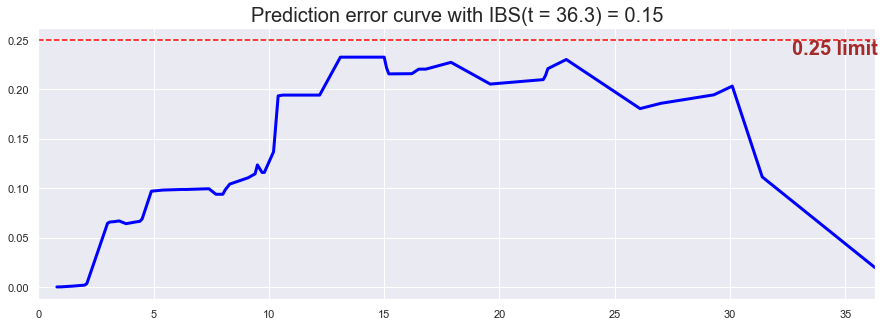

C-index: 0.82
IBS: 0.15

 4 of kfold 5


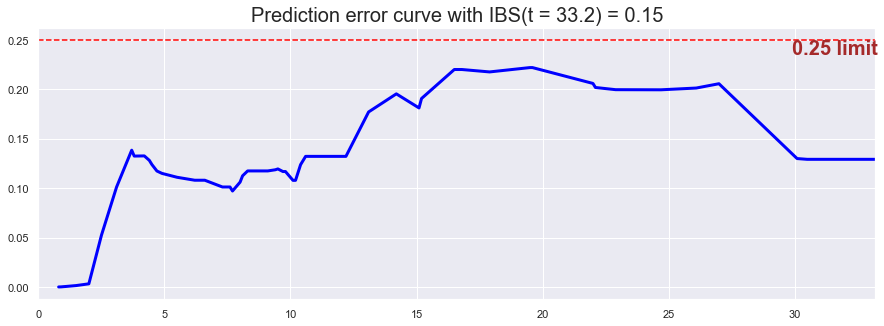

C-index: 0.55
IBS: 0.15

 5 of kfold 5


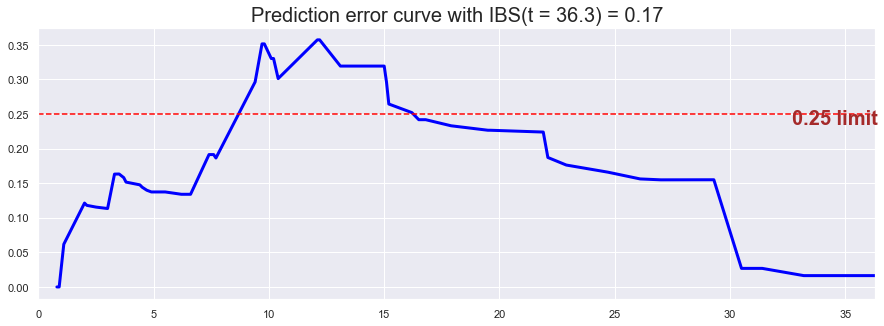

C-index: 0.73
IBS: 0.17

 

                                Data  Best Gridsearch CI    CI Avg    CI STD  \
0                            gtv.csv            0.740742  0.652125  0.074141   
1                  liver_sub_gtv.csv            0.871971  0.771200  0.070599   
2                 liver_plus_gtv.csv            0.673652  0.611003  0.055513   
3             gtv_clin_variables.csv            0.759361  0.699878  0.107242   
4   liver_sub_gtv_clin_variables.csv            0.743941  0.710173  0.078744   
5  liver_plus_gtv_clin_variables.csv            0.833169  0.767285  0.100708   
6            clin_variables_only.csv            0.787101  0.721190  0.108331   

    IBS Avg   IBS STD  Num Trees  Max Depth  Min Node  
0  0.172977  0.018740         20          4         3  
1  0.137301  0.013404         15          6        12  
2  0.194632  0.030327         10          3         5  
3  0.167856  0.019559         20         10         3  
4  0.171217  0.017400         15          4        

In [159]:
# iterating thought each dataset
# all results will be stored in a dataframe with columns "CI, CI STD, IBS, IBS"

results = []

for data_name in data_list:

    # Running feature selection on the data
    
    print('Processing: ' + data_name + '\n')
    processed_file_name = 'filtered_' + data_name 
    
    print('Feature Selecting... \n')
    if(not(os.path.exists(processed_file_name))):
        print('Computing feature selection...\n')
        filtered_data = feature_select(data_name)
    else:
        filtered_data = pd.read_csv(processed_file_name)
        print('Loading existing selected features...\n')
    print('\n \n')

    # running gridsearch
    
    print('Running gridsearch on: ' + data_name + '\n')
    gridsearch_file_name = 'gridsearch_' + data_name 
    
    if(not(os.path.exists(gridsearch_file_name))):
        print('Computing gridsearch...\n')
        (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(filtered_data, data_name)
        print((c_index_best, num_trees_best,_max_depth_best, min_node_best))
    else:
        gridsearch_df = pd.read_csv(gridsearch_file_name)
        
        c_index_best = gridsearch_df['Values'][0]
        num_tree_best = gridsearch_df['Values'][1]
        max_depth_best = gridsearch_df['Values'][2]
        min_node_best = gridsearch_df['Values'][3]
        
        #print(c_index_best)
        print('Loading existing gridsearch hyperparameters...\n')
        
    # generating model form best gridsearch combination

    print('Evaluating K-folds with best hyperparameter combination...\n')
    (CIAvg, CIStd, IBSAvg, IBSStd) = generate_survival_model(filtered_data, num_tree_best, max_depth_best, min_node_best)
    
    results.append([data_name, c_index_best, CIAvg, CIStd, IBSAvg, IBSStd, num_tree_best, max_depth_best, min_node_best])
    print('\n \n')

results_DF = pd.DataFrame(results, columns = ['Data', 'Best Gridsearch CI', 'CI Avg','CI STD','IBS Avg', 'IBS STD', 'Num Trees', 'Max Depth', 'Min Node'])

print(results_DF)

In [160]:
results_DF

,Data,Best Gridsearch CI,CI Avg,CI STD,IBS Avg,IBS STD,Num Trees,Max Depth,Min Node
0,gtv.csv,0.740742,0.652125,0.074141,0.172977,0.018740,20,4,3
1,liver_sub_gtv.csv,0.871971,0.771200,0.070599,0.137301,0.013404,15,6,12
2,liver_plus_gtv.csv,0.673652,0.611003,0.055513,0.194632,0.030327,10,3,5
3,gtv_clin_variables.csv,0.759361,0.699878,0.107242,0.167856,0.019559,20,10,3
4,liver_sub_gtv_clin_variables.csv,0.743941,0.710173,0.078744,0.171217,0.017400,15,4,3
5,liver_plus_gtv_clin_variables.csv,0.833169,0.767285,0.100708,0.141339,0.009392,50,2,15
6,clin_variables_only.csv,0.787101,0.721190,0.108331,0.148428,0.015876,50,1,5


# Old reference code
### using the panda reader import your file where the data is contained

In [148]:
# clinical_data=pd.read_excel('clin_data_dim1_only.xlsx')
clinical_data = pd.read_csv('liver_sub_gtv.csv')

clinical_data

,Unnamed: 0,filename,FFLP,FFLP_in_months,diagnostics_Image-original_Mean,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,0,18284004043,0.0,0.8,-650.732860,0.603414,0.429366,90.057300,209.744909,191.255708,...,496.996658,0.002853,6.661959,0.224866,1.792861e+05,94.229459,0.000005,2901.240190,0.035151,0.007150
1,1,18541330675,0.0,4.2,-785.011777,0.914913,0.703803,114.499498,162.686931,197.838866,...,300.212863,0.009806,7.823879,0.033573,7.360884e+06,59.579096,0.000007,820.770024,0.005038,0.019136
2,2,20243743626,0.0,1.1,-729.302957,0.780417,0.629166,86.815419,137.984998,149.592559,...,518.056125,0.004935,7.367605,0.159763,1.673962e+05,38.666531,0.000012,2126.663835,0.046318,0.016631
3,3,20444767425,1.0,36.3,-677.740532,0.594246,0.508212,97.619877,192.085068,218.874247,...,477.402285,0.004729,7.337764,0.120399,8.021512e+05,61.666741,0.000007,1812.545877,0.036305,0.012660
4,4,20525126502,1.0,2.0,-746.867222,0.623688,0.370911,90.142263,243.029535,295.673080,...,342.913715,0.007161,7.647863,0.106963,6.796121e+05,56.633008,0.000008,1453.121265,0.028608,0.013666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,79,211310175445,1.0,3.8,-680.216740,0.647283,0.442654,96.741168,218.548051,235.336502,...,540.386597,0.001499,6.978312,0.076582,1.838635e+06,66.740238,0.000006,1501.445496,0.012913,0.013103
80,80,211401772640,1.0,9.5,-817.325833,0.768082,0.587806,105.218667,179.002479,188.250562,...,428.458071,0.003594,7.466738,0.064335,2.256018e+06,54.886843,0.000008,1138.590654,0.011888,0.017067
81,81,211502540723,1.0,4.4,-698.505549,0.805310,0.596997,111.338383,186.497245,229.178770,...,445.994521,0.004087,7.606840,0.068773,2.760389e+06,65.672119,0.000006,1282.069251,0.013748,0.014702
82,82,211545340988,1.0,13.1,-690.970603,0.667473,0.381260,92.482554,242.570822,258.686219,...,293.909153,0.004641,6.807994,0.066692,3.289728e+06,109.534480,0.000004,1355.549751,0.007659,0.009933


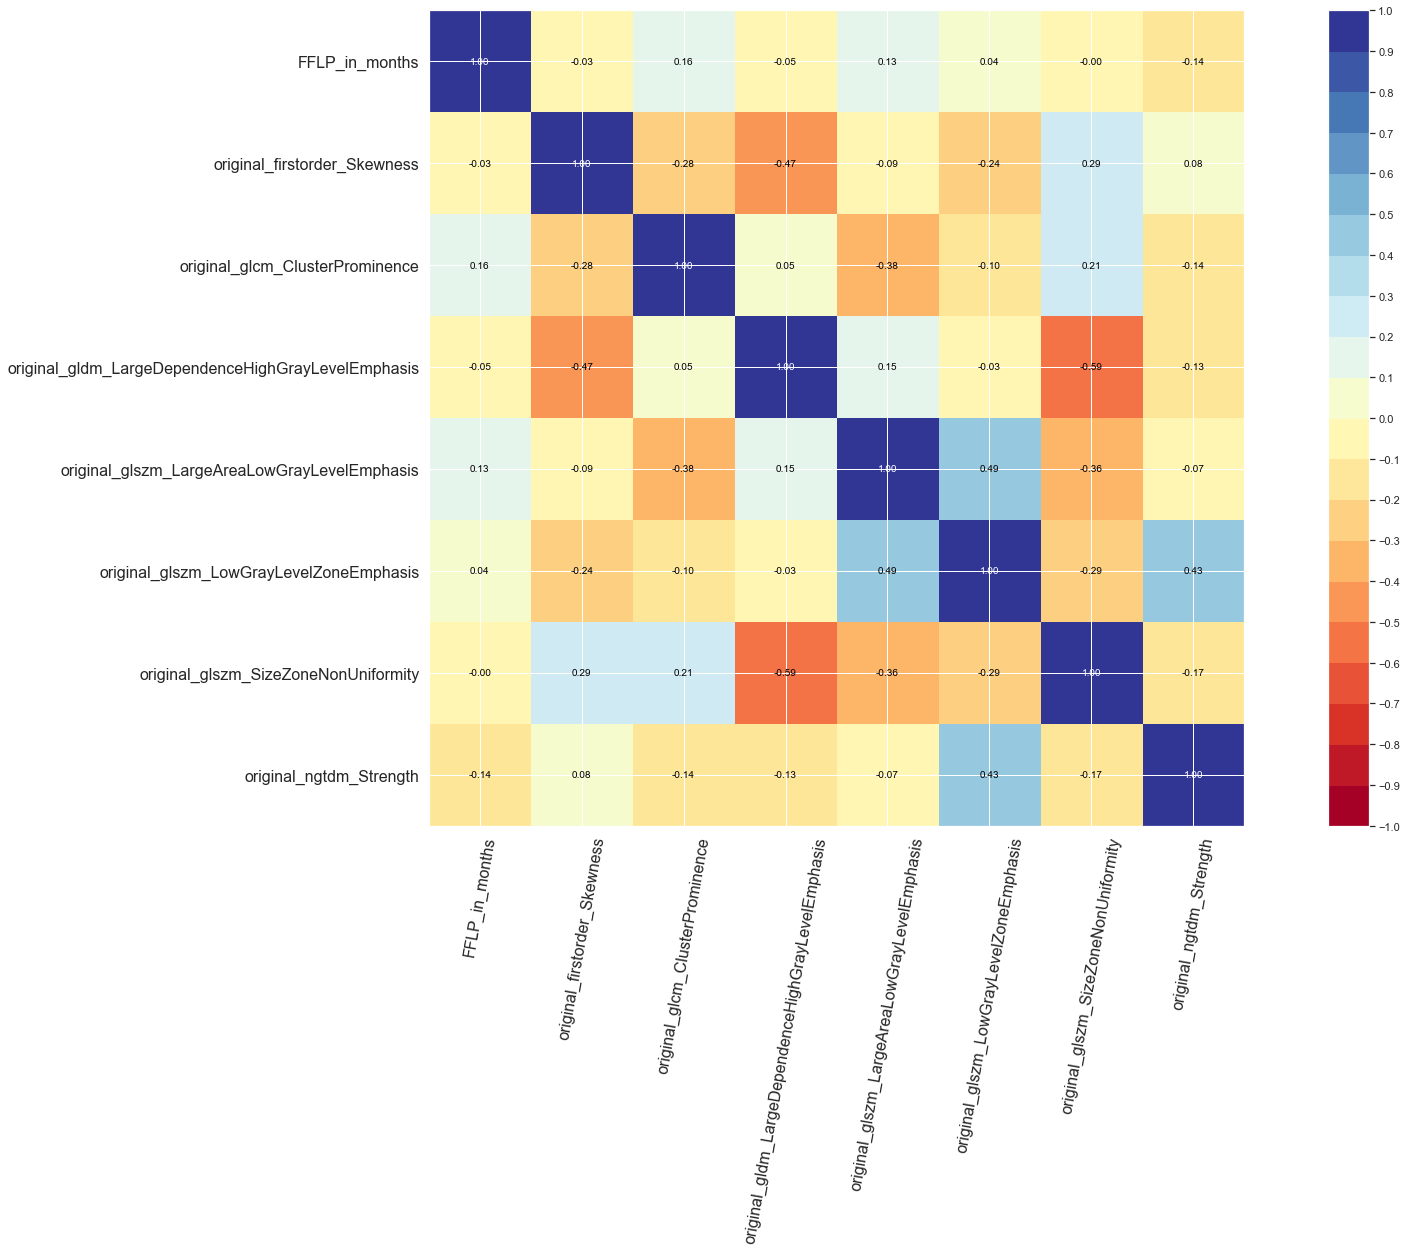

In [159]:
#visualize the full correlation matrix, optional

correlation_matrix(data2_temp[features], figure_size=(30,15), text_fontsize=10)

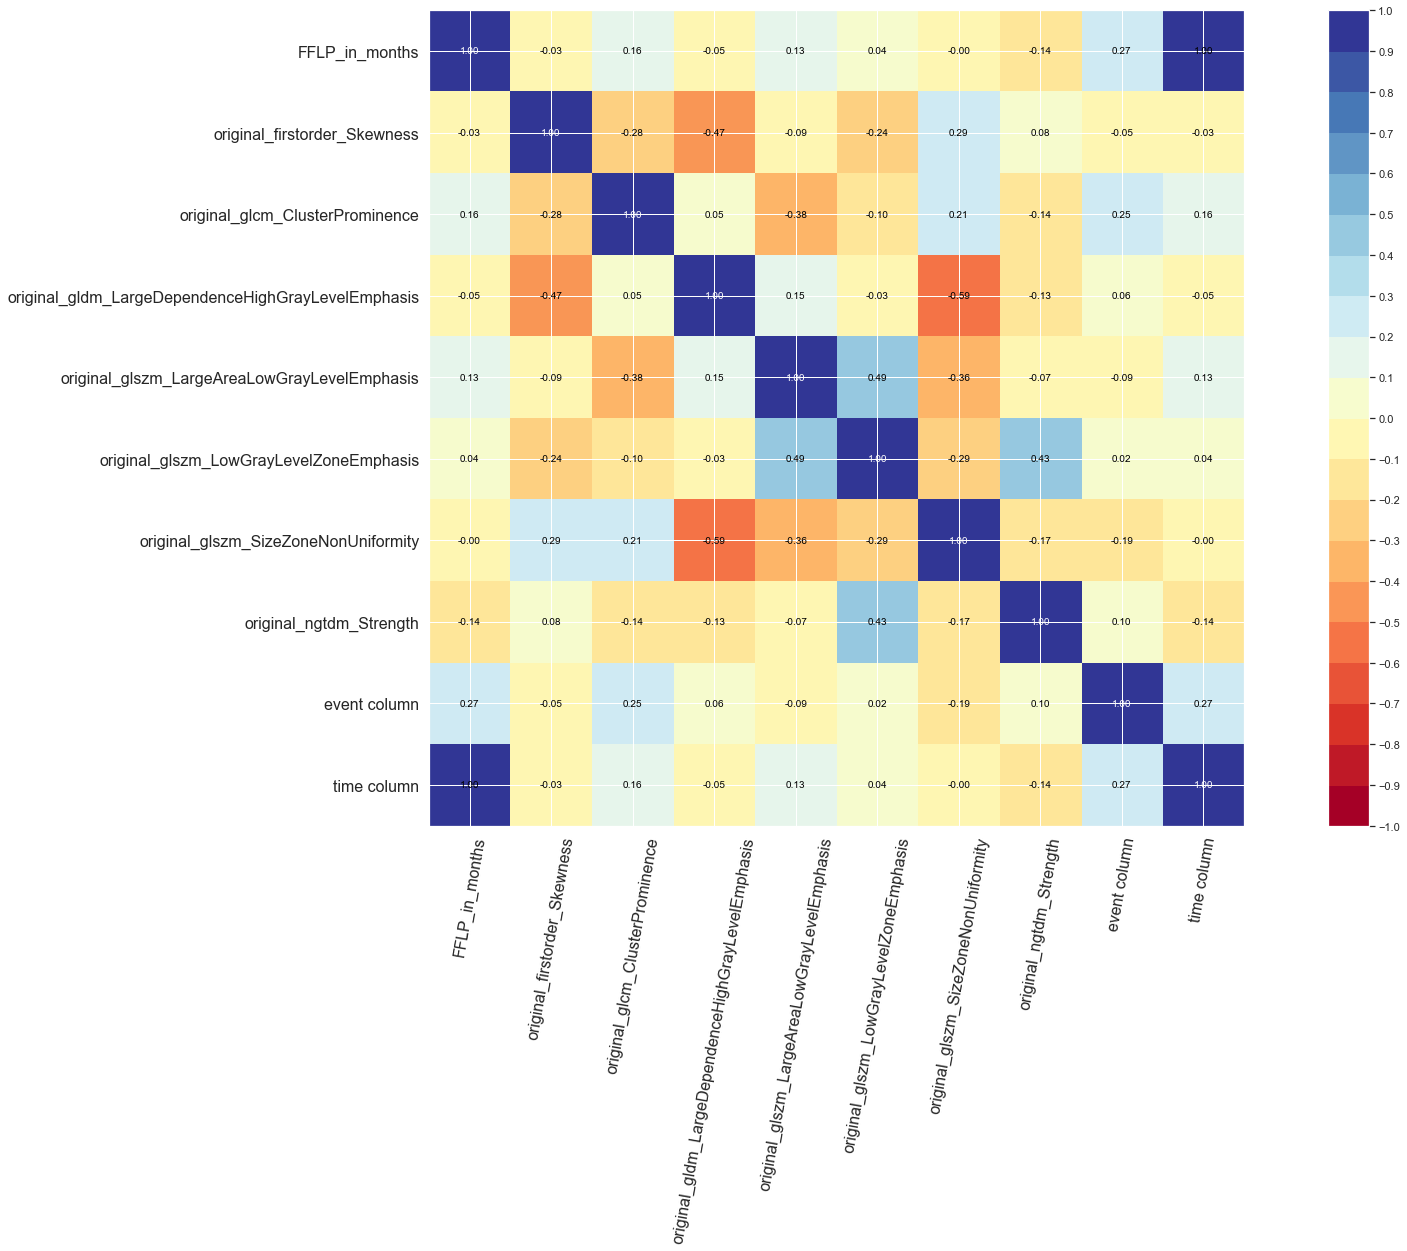

In [160]:
#removing low variance features
data_temp = data2

for cols in data2.columns:
    if np.var(data2[cols]) == 0:
        print('Dropping: ' + cols)
        data_temp = data_temp.drop(columns=cols)

data2 = data_temp
features=np.setdiff1d(data2.columns, [time_column, event_column]).tolist()
correlation_matrix(data2, figure_size=(30,15), text_fontsize=10)

In [58]:
xst.variable_importance_table.head(20)


,feature,importance,pct_importance
0,original_glrlm_LongRunLowGrayLevelEmphasis,1.877480,0.106444
1,original_firstorder_Maximum,1.829604,0.103729
2,original_shape_Maximum2DDiameterSlice,1.667590,0.094544
3,original_firstorder_Variance,1.549064,0.087824
4,original_firstorder_Kurtosis,1.521446,0.086258
5,original_firstorder_InterquartileRange,1.483783,0.084123
6,original_gldm_DependenceVariance,1.270569,0.072035
7,original_firstorder_Minimum,1.252106,0.070988
8,original_shape_SurfaceVolumeRatio,1.175887,0.066667
9,original_firstorder_TotalEnergy,1.162897,0.065930


In [39]:
# getting sample predictions


preds = xst.predict_survival(data1.iloc[:,:-2].transpose())
preds_df = pd.DataFrame(preds).T
preds_df.to_excel('preds.xlsx')

In [64]:
def selection_sort(x):
    for i in range(len(x)):
        swap = i + np.argmin(x[i:])
        (x[i], x[swap]) = (x[swap], x[i])
    return x

preds = pd.DataFrame(columns = ['Preds','Actual'])
preds['Preds'] = xst.times
actuals = selection_sort(data2['time column'])
preds['Actual'] = data2['time column']
print(preds)


    Preds  Actual
0    -2.4    -2.4
1    -1.8    -1.8
2    -1.4    -1.4
3    -0.9    -0.9
4     0.8     0.8
5     0.9     0.8
6     1.0     0.9
7     1.1     1.0
8     1.5     1.1
9     1.9     1.5
10    2.0     1.9
11    2.1     2.0
12    2.5     2.1
13    3.0     2.1
14    3.3     2.5
15    3.5     3.0
16    3.8     3.1
17    4.4     3.3
18    4.5     3.5
19    4.9     3.8
20    5.5     3.8
21    6.2     3.8
22    6.6     3.8
23    7.3     4.4
24    7.4     4.4
25    7.7     4.4
26    8.0     4.5
27    8.1     4.7
28    8.3     4.9
29    9.4     5.5
30    9.8     6.2
31   10.1     6.2
32   10.2     6.4
33   10.4     6.6
34   10.6     7.3
35   11.2     7.4
36   12.1     7.6
37   13.1     7.7
38   14.2     8.0
39   15.2     8.1
40   16.2     8.3
41   16.5     9.1
42   16.8     9.4
43   19.5     9.4
44   19.6     9.4
45   21.9     9.4
46   22.1     9.5
47   22.9     9.8
48   24.7    10.1
49   26.1    10.2
50   27.0    10.4
51   29.3    10.4
52   30.1    10.6
53   30.5    11.2
54   31.4 

3.494355248975368e-10